# Model downloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path_stylegan2_ada = os.path.join(cwd, '..', 'tools', 'stylegan2_ada_utils')
api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')


sys.path.append(api_path_stylegan2_ada)
sys.path.append(api_path_sampling)
sys.path.append(api_path_gan_metrics)

In [3]:
import os
import re
from typing import List, Optional

import click
import numpy as np
import PIL.Image
import torch
import random
from functools import partial

import legacy
import dnnlib

from matplotlib import pyplot as plt

In [4]:
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl'

device = torch.device('cuda:1')
with dnnlib.util.open_url(network_pkl) as f:
    file = legacy.load_network_pkl(f)
    G = file['G_ema'].to(device)
    D = file['D'].to(device)

In [5]:
truncation_psi = 1
noise_mode = 'const'

In [6]:
seed = 42
batch_size = 64
z = torch.from_numpy(np.random.RandomState(seed).randn(batch_size, G.z_dim)).to(device)
label = torch.zeros([batch_size, G.c_dim], device=device)
img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
img_numpy = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [7]:
def plot_images(images_numpy):
    batch_size_sample = images_numpy.shape[0]
    nrow = int(batch_size_sample**0.5)
    fig = plt.figure(figsize=(15, 15))
    axes = fig.subplots(nrow, nrow)
    for k in range(batch_size_sample):
        i = k // nrow
        j = k % nrow
        #axes[i][j].imshow(np.clip(numpy_images[k], 0, 1))
        axes[i][j].imshow(images_numpy[k])
        axes[i][j].axis('off')
    plt.show()

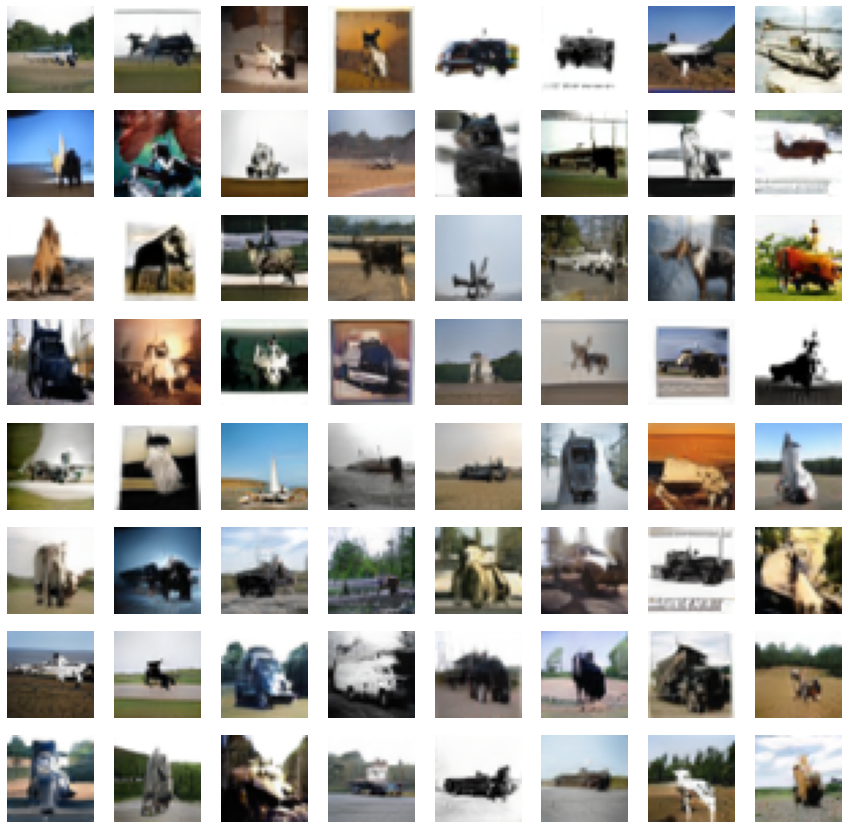

In [8]:
plot_images(img_numpy)

In [21]:
result = D(img, label)

In [23]:
label.shape

torch.Size([64, 10])

# Calculating metrics

In [10]:
from simple_calc_metrics import calc_metrics

metrics = ['fid50k_full']
mirror = 0 # FALSE/TRUE?????
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl'
gpus = 1
verbose = True
data = '/home/daniil/gans-mcmc/stylegan2-ada_logs/cifar10.zip'
ctx = None

In [11]:
calc_metrics(ctx, network_pkl, metrics, data, mirror, gpus, verbose)

list of valid metrics = ['fid50k_full', 'kid50k_full', 'pr50k3_full', 'ppl2_wend', 'is50k', 'fid50k', 'kid50k', 'pr50k3', 'ppl_zfull', 'ppl_wfull', 'ppl_zend', 'ppl_wend']
Loading network from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl"...
Dataset options:
{
  "class_name": "training.dataset.ImageFolderDataset",
  "path": "/home/daniil/gans-mcmc/stylegan2-ada_logs/cifar10.zip",
  "resolution": 32,
  "use_labels": true,
  "xflip": 0
}
Launching processes...

Generator            Parameters  Buffers  Output shape      Datatype
---                  ---         ---      ---               ---     
mapping.embed        5632        -        [1, 512]          float32 
mapping.fc0          524800      -        [1, 512]          float32 
mapping.fc1          262656      -        [1, 512]          float32 
mapping              -           512      [1, 8, 512]       float32 
synthesis.b4.conv1   2622465     32       [1, 512, 4, 4]    float32 
synthesis.b4.torgb 

# ULA

In [8]:
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from distributions import IndependentNormal
import torchvision.transforms as transforms

from general_utils import to_var, DotDict, to_np

In [9]:
loc = torch.zeros(G.z_dim).to(device)
scale = torch.ones(G.z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

In [10]:
log_prob = True
normalize_to_0_1 = True

def gan_energy_stylegan2_ada(z, generator, discriminator, truncation_psi, noise_mode,
                             proposal, normalize_to_0_1, log_prob=False, z_transform=None):
    label = torch.zeros([z.shape[0], generator.c_dim], device=z.device)
    if z_transform is None:
        generator_points = generator(z, label, 
                                     truncation_psi=truncation_psi, noise_mode=noise_mode)
    else:
        generator_points = generator(z_transform(z), label, 
                                     truncation_psi=truncation_psi, noise_mode=noise_mode)
    if normalize_to_0_1:
        gan_part = -discriminator(generator_points, label).view(-1)
    else:
        sigmoid_gan_part = discriminator(generator_points, label)
        gan_part = -(torch.log(sigmoid_gan_part) - \
                     torch.log1p(-sigmoid_gan_part)).view(-1)
        
    proposal_part = -proposal.log_prob(z)

    energy = gan_part + proposal_part
    if not log_prob:
        return energy
    else:
        return -energy

target_gan = partial(gan_energy_stylegan2_ada,
                     generator = G, 
                     discriminator = D, 
                     truncation_psi = truncation_psi,
                     noise_mode = noise_mode,
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [13]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 64
n = 50000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_stylegan2_ada'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5
continue_z = None

z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)


  0%|          | 1/782 [00:27<5:54:15, 27.22s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_stylegan2_ada_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_0.npy was saved, file shape = (21, 64, 512)


  0%|          | 1/782 [00:34<7:27:00, 34.34s/it]


KeyboardInterrupt: 